# SMYLE & DPLE Global Surface Temperature Skill

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [42]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_mid(ds0,'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [7]:
%%time
# SMYLE-NOV TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunk = {'M':20,'L':8}
chunk = {}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 42.6 s, sys: 19 s, total: 1min 1s
Wall time: 1min 21s


3.468172712

In [8]:
%%time
smyle11=smyle11.load()
#daskresult = wait(smyle11)

CPU times: user 59.6 s, sys: 5.66 s, total: 1min 5s
Wall time: 1min 4s


In [9]:
%%time
# SMYLE-FEB TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunk = {'M':20,'L':8}
chunk = {}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

CPU times: user 42.1 s, sys: 18.2 s, total: 1min
Wall time: 1min 6s


3.468172712

In [10]:
%%time
smyle02=smyle02.load()
#daskresult = wait(smyle02)

CPU times: user 1min 1s, sys: 5.47 s, total: 1min 6s
Wall time: 1min 6s


In [11]:
%%time
# SMYLE-MAY TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 44.5 s, sys: 18.6 s, total: 1min 3s
Wall time: 1min 21s


3.468172712

In [12]:
%%time
smyle05=smyle05.load()

CPU times: user 1min 6s, sys: 5.73 s, total: 1min 12s
Wall time: 1min 12s


In [13]:
%%time
# SMYLE-AUG TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 42.6 s, sys: 18.6 s, total: 1min 1s
Wall time: 1min 8s


3.468172712

In [14]:
%%time
smyle08=smyle08.load()

CPU times: user 1min 7s, sys: 6 s, total: 1min 13s
Wall time: 1min 13s


In [15]:
%%time
# DPLE-NOV TS data
# process all 40 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
dple11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
dple11.nbytes/1e9 #GB

CPU times: user 32.8 s, sys: 3.35 s, total: 36.1 s
Wall time: 48.3 s


6.79478016

In [16]:
%%time
dple11=dple11.load()

CPU times: user 2min 14s, sys: 12.2 s, total: 2min 27s
Wall time: 2min 25s


### DataArrays are manageable size now (and in memory), so Dask cluster could be released 

In [28]:
cluster.close()
client.close()

In [18]:
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11.to_netcdf(outdir+'DPLE11_SAT_seas.nc')
smyle11.to_netcdf(outdir+'SMYLE11_SAT_seas.nc')
smyle02.to_netcdf(outdir+'SMYLE02_SAT_seas.nc')
smyle05.to_netcdf(outdir+'SMYLE05_SAT_seas.nc')
smyle08.to_netcdf(outdir+'SMYLE08_SAT_seas.nc')

In [ ]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11 = xr.open_dataset(outdir+'DPLE11_SAT_seas.nc')
smyle11 = xr.open_dataset(outdir+'SMYLE11_SAT_seas.nc')
smyle02 = xr.open_dataset(outdir+'SMYLE02_SAT_seas.nc')
smyle05 = xr.open_dataset(outdir+'SMYLE05_SAT_seas.nc')
smyle08 = xr.open_dataset(outdir+'SMYLE08_SAT_seas.nc')

### Get surface temperature OBS

In [19]:
# CRU TS4.05  (0.5deg SAT over land)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_cru = xr.open_dataset(obs_dir+'mon/SAT/cru_ts4.05.1901.2020.tmp.dat.nc',decode_times=False)
cru_montime_vals = [cftime.DatetimeNoLeap(1901+year, 1+month, 15) for year in range(120) for month in range(12)]
ds_cru['time'] = cru_montime_vals
ds_cru = ds_cru.sel(time=slice("1960","2020"))

In [20]:
# ERSSTv5  (2deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_ersstv5 = xr.open_dataset(obs_dir+'mon/SST/ersst.v5.188001-202012.nc')
nt = np.size(ds_ersstv5.time)
ersstv5_montime_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_ersstv5['time'] = ersstv5_montime_vals
ds_ersstv5 = ds_ersstv5.sel(time=slice("1960","2020"))

In [21]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_hadisst.time)
hadisst_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])
ds_hadisst = ds_hadisst.sel(time=slice("1960","2020"))

### Compute OBS seasonal averages

In [22]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [23]:
cru_ts_seas = obs_convert_mon_to_seas(ds_cru.tmp,'TS')

In [24]:
ersstv5_ts_seas = obs_convert_mon_to_seas(ds_ersstv5.sst,'TS')

In [25]:
hadisst_ts_seas = obs_convert_mon_to_seas(ds_hadisst.sst,'TS')

### Regrid OBS to CAM grid

In [26]:
import xesmf as xe

In [27]:
%%time
regridder_cru = xe.Regridder(cru_ts_seas, smyle11, 'bilinear', periodic=True)
cru_ts_seas_rg = regridder_cru(cru_ts_seas.TS)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 5.14 s, sys: 365 ms, total: 5.5 s
Wall time: 5.23 s


In [28]:
%%time
regridder_hadisst = xe.Regridder(hadisst_ts_seas, smyle11, 'bilinear', periodic=True)
hadisst_ts_seas_rg = regridder_hadisst(hadisst_ts_seas.TS)

CPU times: user 2.29 s, sys: 196 ms, total: 2.49 s
Wall time: 2.35 s


### Merge OBS datasets

In [29]:
def merge_obs(da1,da2):
    return da1.fillna(da2)

In [30]:
# merged CRU/HadISST
#cruhadisst = merge_obs_camgrid(cru_ts_seas_rg,hadisst_ts_seas_rg,fv1_landmask.LANDFRAC,0.5)
cruhadisst = merge_obs(cru_ts_seas_rg,hadisst_ts_seas_rg)

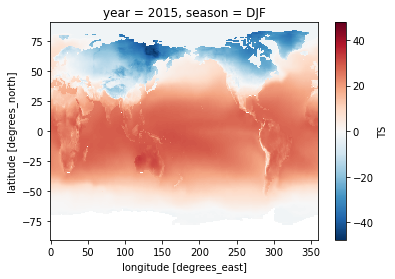

In [31]:
cruhadisst.isel(season=0).sel(year=2015).plot();

In [32]:
## convert OBS to anomalies from 1972-2017
cruhadisst = cruhadisst - cruhadisst.sel(year=slice(1972,2017)).mean('year')

# Anomaly Correlation Plots

In [28]:
%%time
# SKIP this.. could not get chunking and dask to speed things up
#chunks = {'M':1}
# Compute de-drifted anomalies from 1972-2017 climatology
#smyle11_anom,smyle11_clim = stat.remove_drift(smyle11.chunk(chunks),smyle11.time,1972,2017)
#dple11_anom,dple11_clim = stat.remove_drift(dple11.chunk(chunks),dple11.time,1972,2017)
#smyle02_anom,smyle02_clim = stat.remove_drift(smyle02.chunk(chunks),smyle02.time,1972,2017)
#smyle05_anom,smyle05_clim = stat.remove_drift(smyle05.chunk(chunks),smyle05.time,1972,2017)
#smyle08_anom,smyle08_clim = stat.remove_drift(smyle08.chunk(chunks),smyle08.time,1972,2017)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


In [33]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11,smyle11time,1972,2017)
dple11_anom,dple11_clim = stat.remove_drift(dple11,dple11time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02,smyle02time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05,smyle05time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08,smyle08time,1972,2017)

CPU times: user 18.8 s, sys: 13.6 s, total: 32.5 s
Wall time: 30.1 s


In [34]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_corr_byseas(mod_da,mod_time,obs_da,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [35]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11.time,cruhadisst)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11.time,cruhadisst)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02.time,cruhadisst)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05.time,cruhadisst)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08.time,cruhadisst)

CPU times: user 17.8 s, sys: 6.54 s, total: 24.3 s
Wall time: 22.8 s


CPU times: user 52.4 s, sys: 4.18 s, total: 56.6 s
Wall time: 51.4 s


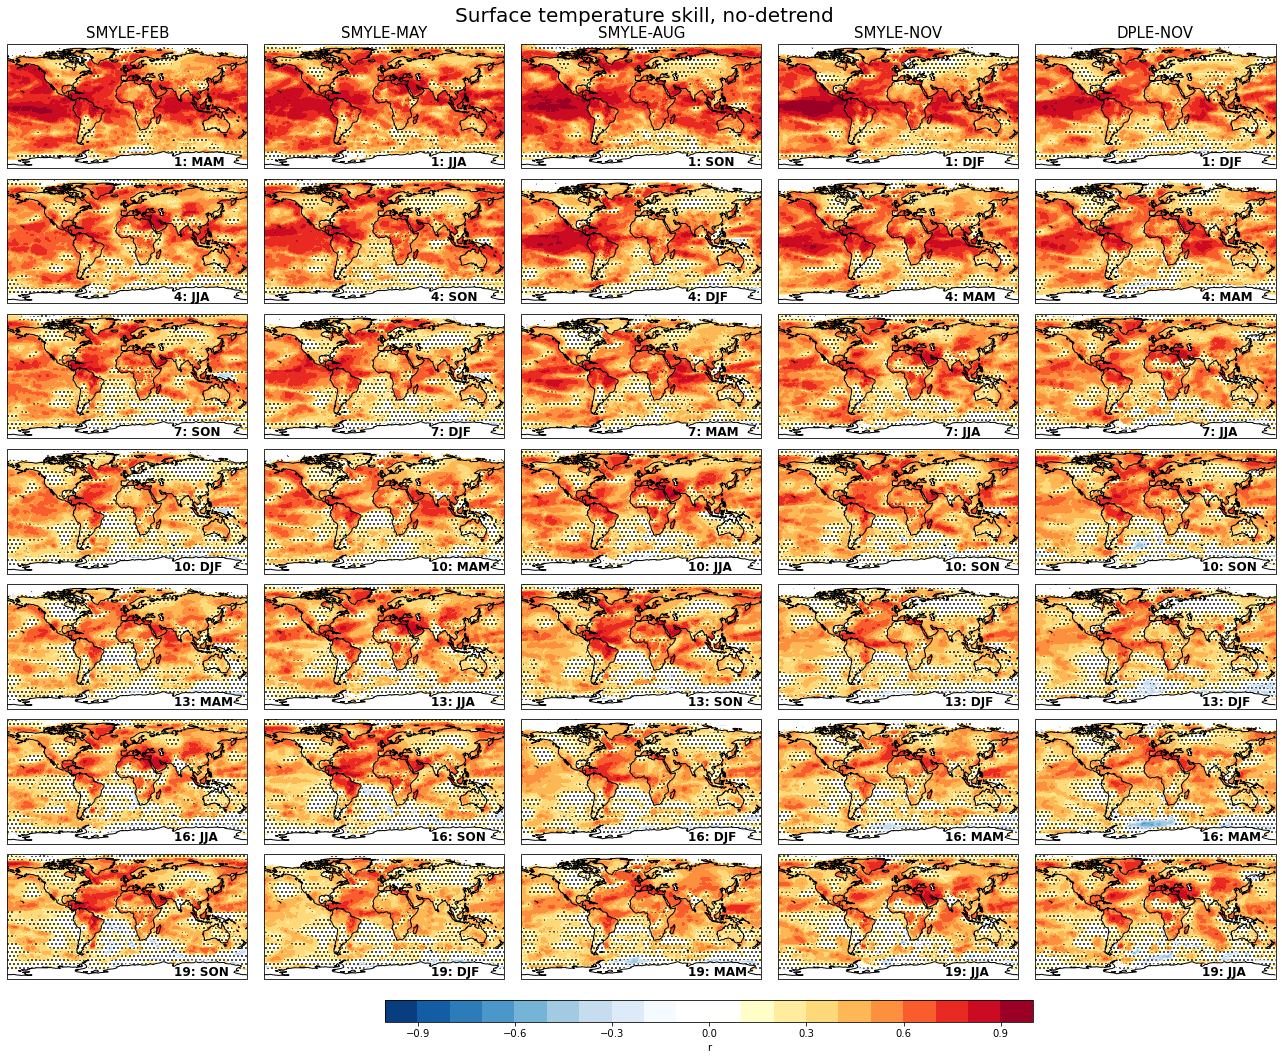

In [36]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')

### Test Significance Hatching using correlation p-values

CPU times: user 1.48 s, sys: 129 ms, total: 1.61 s
Wall time: 1.49 s


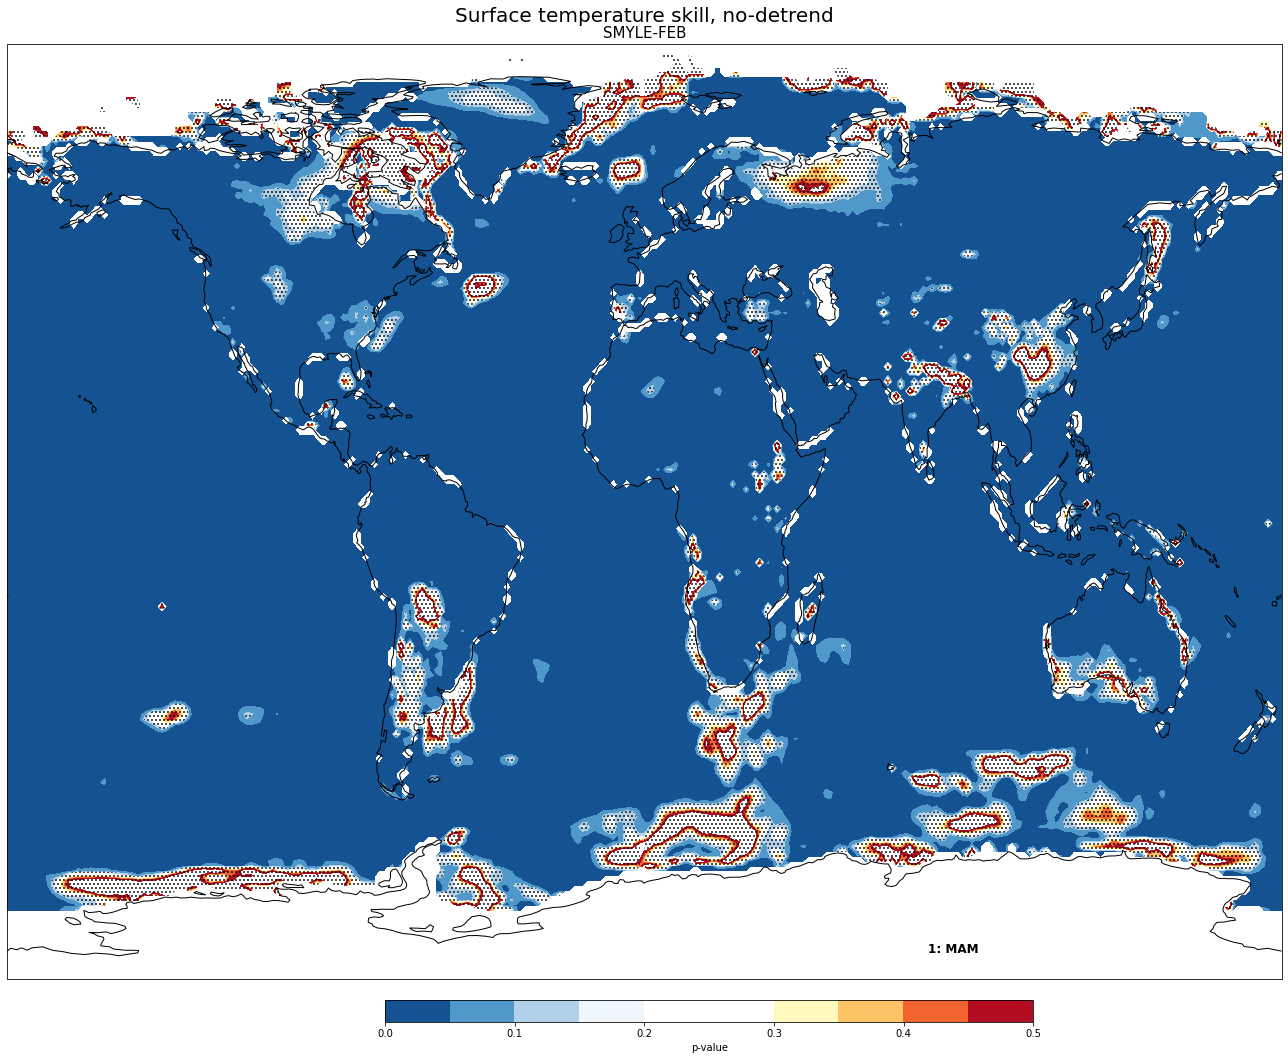

In [36]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...','...'], alpha=0.)
    ldstr = str(i+1) + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [37]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11.time,cruhadisst,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11.time,cruhadisst,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02.time,cruhadisst,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05.time,cruhadisst,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08.time,cruhadisst,detrend=True)

CPU times: user 42.4 s, sys: 8.96 s, total: 51.4 s
Wall time: 47.3 s


CPU times: user 1min 19s, sys: 5.23 s, total: 1min 24s
Wall time: 1min 18s


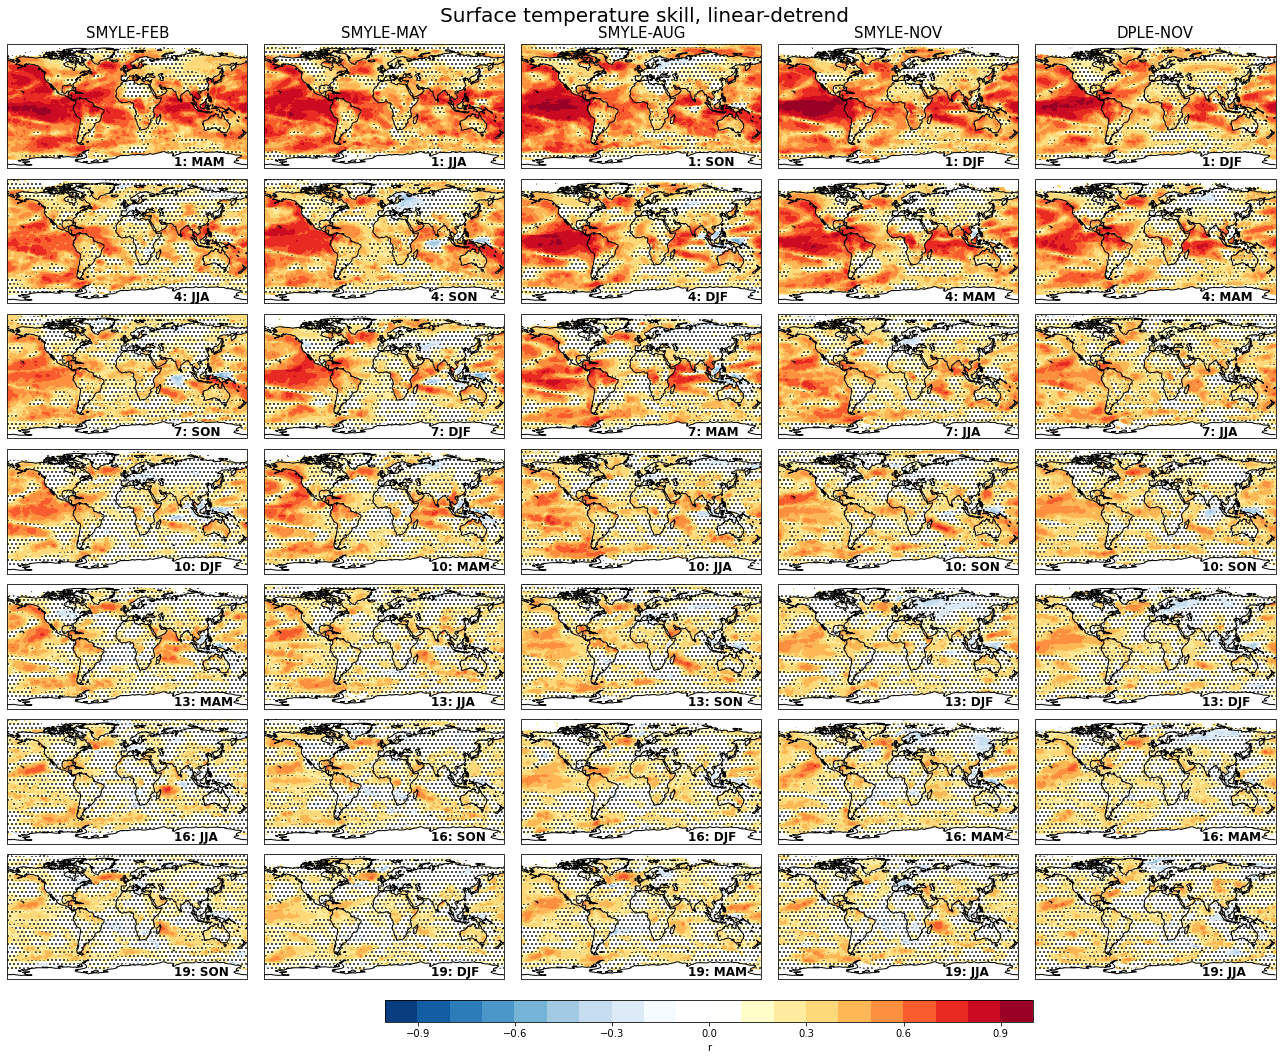

In [38]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_SATskillmaps.png')

### Look at subsampled skill maps

In [39]:
hadisst_ts_seas.TS.sel(year=slice(1970,2018)).year

<xarray.DataArray 'year' (year: 49)>
array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])
Coordinates:
  * year     (year) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018

In [40]:
obs_dat = hadisst_ts_seas.TS.sel(year=slice(1970,2018))
obs_nino34 = obs_dat.sel(latitude=slice(5,-5)).sel(longitude=slice(-170,-120)).mean(("longitude", "latitude"))

In [41]:
obs_nino34 = obs_nino34 - obs_nino34.mean('year')
obs_nino34 = obs_nino34/obs_nino34.std('year')

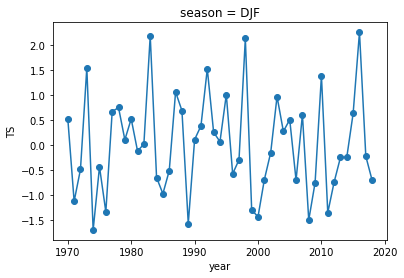

In [42]:
obs_nino34.sel(season='DJF').plot(marker='o');

In [43]:
bignino = obs_nino34.where(abs(obs_nino34)>1)

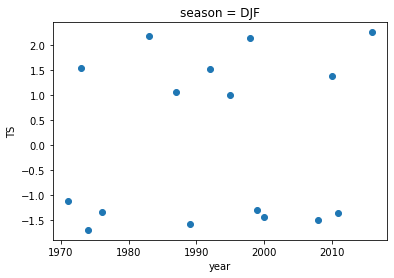

In [44]:
bignino.sel(season='DJF').plot(marker='o',linestyle="none");

In [45]:
bignino.sel(season='DJF').dropna(dim='year').year

<xarray.DataArray 'year' (year: 16)>
array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999, 2000,
       2008, 2010, 2011, 2016])
Coordinates:
  * year     (year) int64 1971 1973 1974 1976 1983 ... 2000 2008 2010 2011 2016
    season   <U3 'DJF'

In [46]:
keepyears = bignino.sel(season='DJF').dropna(dim='year').year.data

In [47]:
keepyears

array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999,
       2000, 2008, 2010, 2011, 2016])

In [48]:
def leadtime_corr_byseas_subsamp(mod_da,mod_time,obs_da,keep,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M').sel(Y=keep)
    mod_time = mod_time.sel(Y=keep)
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        verify_year = mod_time.sel(L=i).dt.year.data
        verify_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[verify_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",verify_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [49]:
%%time
keep11 = (keepyears-1)
keep02 = keepyears
keep05 = keepyears
keep08 = (keepyears-1)
smyle11_corr = leadtime_corr_byseas_subsamp(smyle11_anom.TS,smyle11.time,cruhadisst,keep11,detrend=True)
dple11_corr = leadtime_corr_byseas_subsamp(dple11_anom.TS,dple11.time,cruhadisst,keep11,detrend=True)
smyle02_corr = leadtime_corr_byseas_subsamp(smyle02_anom.TS,smyle02.time,cruhadisst,keep02,detrend=True)
smyle05_corr = leadtime_corr_byseas_subsamp(smyle05_anom.TS,smyle05.time,cruhadisst,keep05,detrend=True)
smyle08_corr = leadtime_corr_byseas_subsamp(smyle08_anom.TS,smyle08.time,cruhadisst,keep08,detrend=True)

CPU times: user 34.2 s, sys: 6.82 s, total: 41 s
Wall time: 37.8 s


CPU times: user 1min 36s, sys: 6.55 s, total: 1min 42s
Wall time: 1min 34s


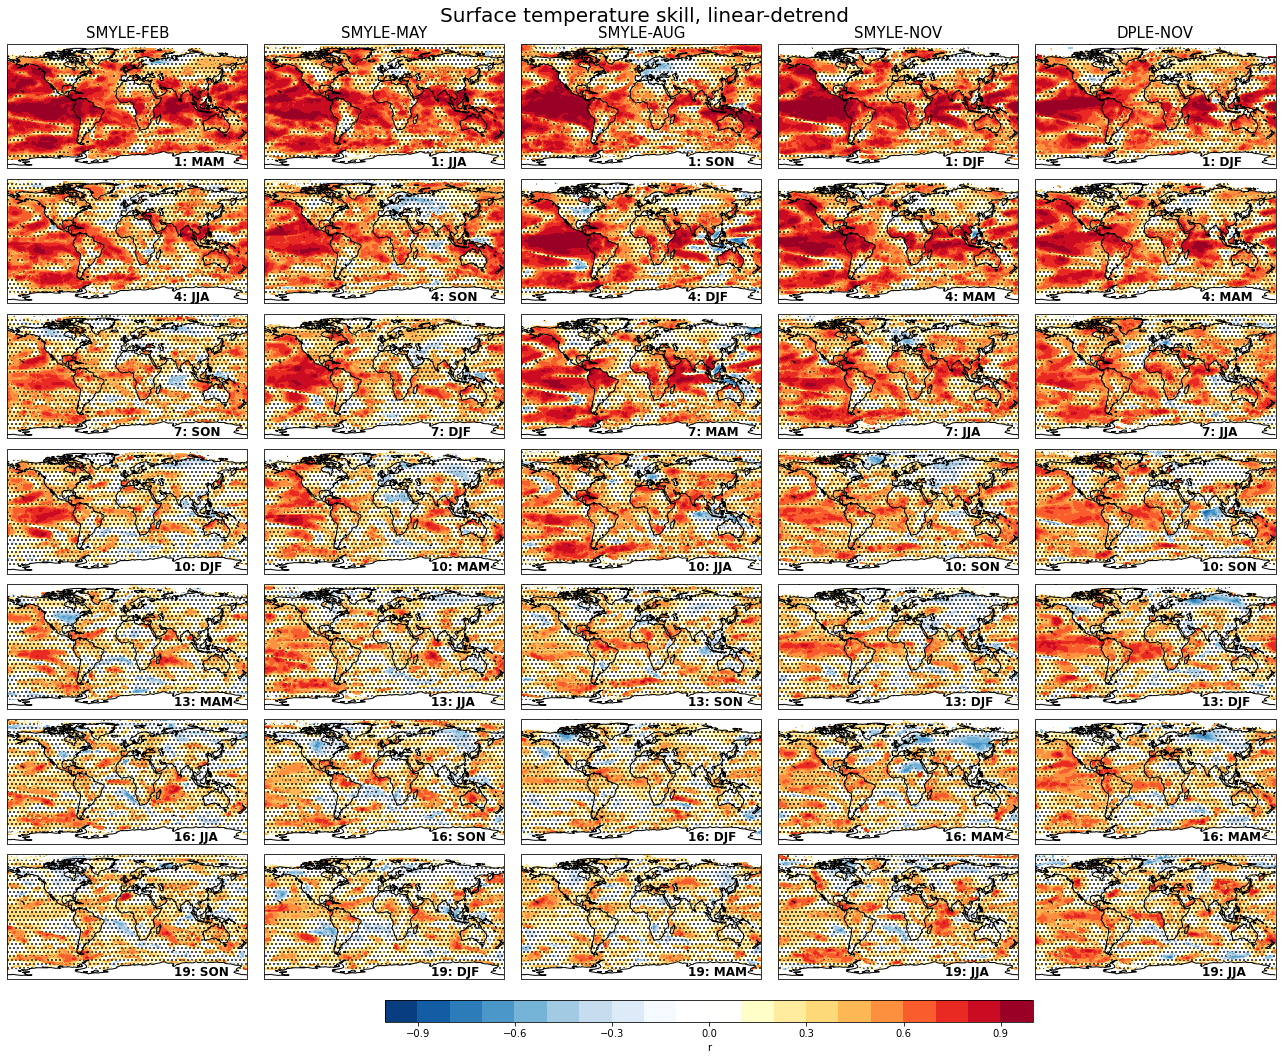

In [50]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_SATskillmaps_subsamp.png')

### Test skill sensitivity to OBS dataset: use HadCRU5-ERSSTv5

In [68]:
# Xian Wu's merged HadCRU5-ERSSTv5 data on CAM fv1 grid
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_obs = xr.open_dataset(obs_dir+'mon/merge_ocean_land_data/merge-ts-sst-obsdata-HadCRUT5-ERSSTv5-1900-2020.nc')
nt = np.size(ds_obs.time)
obs_montime_vals = [cftime.DatetimeNoLeap(1900+year, 1+month, 15) for year in range(121) for month in range(12)]
ds_obs['time'] = obs_montime_vals
ds_obs = ds_obs.sel(time=slice("1960","2020"))

In [69]:
obs_ts_seas = obs_convert_mon_to_seas(ds_obs.ts,'TS').TS

In [70]:
## convert OBS to anomalies from 1972-2017
obs_ts_seas = obs_ts_seas - obs_ts_seas.sel(year=slice(1972,2017)).mean('year')

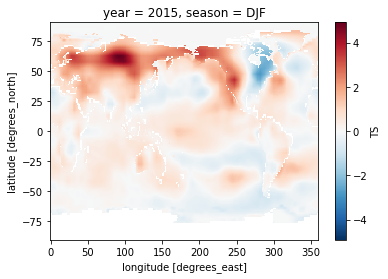

In [71]:
obs_ts_seas.isel(season=0).sel(year=2015).plot();

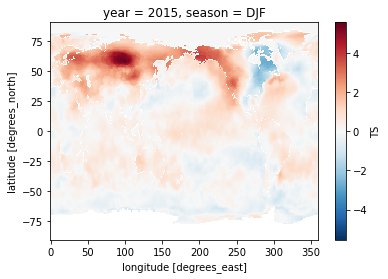

In [72]:
cruhadisst.isel(season=0).sel(year=2015).plot();

In [73]:
## need to correct obs grid which is slightly off:
obs_ts_seas = obs_ts_seas.assign_coords(lat=("lat",smyle11.lat.data)).assign_coords(lon=("lon",smyle11.lon.data))

In [81]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11.time,obs_ts_seas,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11.time,obs_ts_seas,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02.time,obs_ts_seas,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05.time,obs_ts_seas,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08.time,obs_ts_seas,detrend=True)

CPU times: user 37.8 s, sys: 9.14 s, total: 47 s
Wall time: 44.9 s


CPU times: user 44.9 s, sys: 133 ms, total: 45.1 s
Wall time: 44.9 s


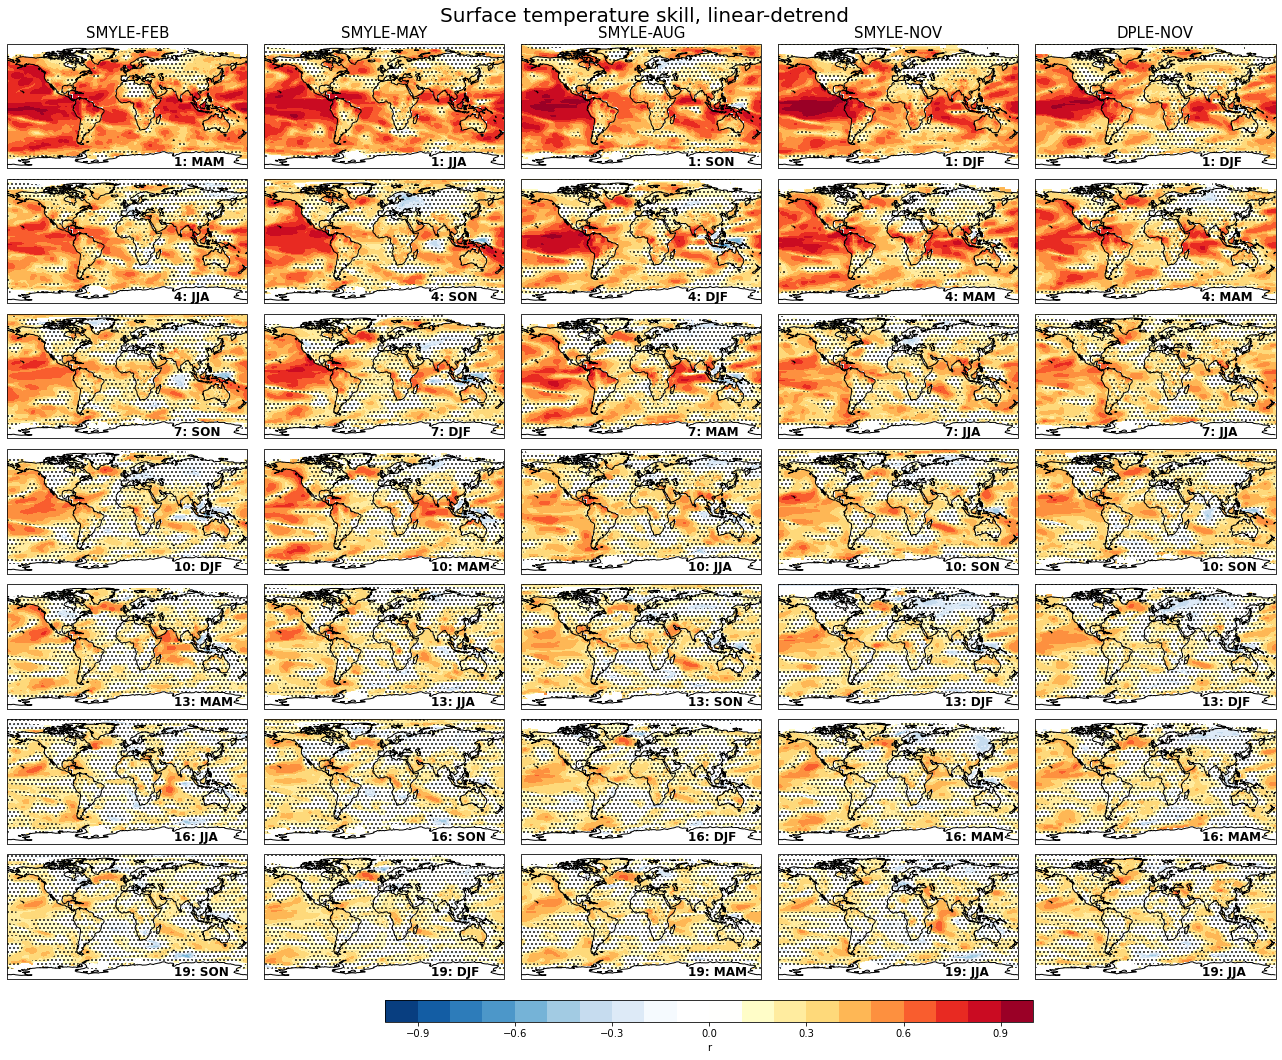

In [82]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_1b.png')